<a href="https://colab.research.google.com/github/EduS3000/KURF2023/blob/main/KURF2023_location_of_RotorPoint.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [146]:
# Notebook for processing and training deep learning model for the synthetic ECG data

# Try with Leaky Rely for dying neurons as well, Softmax activation and Cross entropy (normal) for loss
#Alexis is my god

In [147]:
# Import necessary modules:
import os,glob
import torch
import os.path
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import csv as csv
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.python.keras.layers import Flatten, Dense
from tensorflow.keras.optimizers import Adam
from torch.nn.modules.loss import CrossEntropyLoss
from sklearn.metrics import accuracy_score


In [148]:
# Load in data from Google Drive:
# Mount drive:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [149]:
folder_path = "/content/drive/MyDrive/KURF2023/Method 2 data 04-07 Both spiral locations - 200"
fileNames = []

In [ ]:
# Iterate through directory:
for path in os.listdir(folder_path):
    # Check if current path is a file
    if os.path.isfile(os.path.join(folder_path, path)):
        fileNames.append(path)
print(fileNames)

In [151]:
# Get expected length for each ECG trace:
full_path = os.path.join(folder_path, fileNames[1])
ECGfile = open(full_path, 'r');
count = 0
for lineCount in ECGfile:
    if count<1:
        listFloats = lineCount.split("\t")
        x = list(np.float_(listFloats))
        num_traces = len(x)
    count += 1

In [152]:
# Possible rotor/focal point positions:
Possible_coordinates = [[30,30], [75,75]]

# Assign value for each coordinate (2 in this case):
Coord1 = 0
Coord2 = 1

In [ ]:
# Full dataset:

# Initialise all data sets:
# Location:
Full_ECG_coordinates = []
# Values:
Full_ECG_Sets = []

countee = 0

print('Loading')

for f in range(len(fileNames)):
    rel_path = fileNames[f]
    # Get coordinates from title of .txt file:
    c1Start = rel_path.find('er_') + 3
    c1End = c1Start+2
    c2End = rel_path.find('_ite')
    c2Start = c2End-2
    patch1Start = rel_path.find('on_') + 3
    patch1End = patch1Start+2
    patch2End = rel_path.find('_Lii')
    patch2Start = patch2End-2

    C1 = int(rel_path[c1Start:c1End])
    C2 = int(rel_path[c2Start:c2End])
    CP1 = int(rel_path[patch1Start:patch1End])
    CP2 = int(rel_path[patch2Start:patch2End])
    Coords = [C1,C2]
    #Patch_coords = [CP1,CP2]

    if True:
      countee = countee + 1
      abs_file_path = os.path.join(folder_path, rel_path)
      print(abs_file_path)

      # Check which coordinate to assign to:
      if (Coords == [30,30]):
        Full_ECG_coordinates.append([0])
      elif (Coords == [75,75]):
        Full_ECG_coordinates.append([1])
      Pwaves_Lii = np.zeros(count)
      Pwaves_Liii = np.zeros(count)
      Pwaves_WCT = np.zeros(count)
      Pwaves_V1 = np.zeros(count)
      Pwaves_V2 = np.zeros(count)
      Pwaves_V3 = np.zeros(count)
      Pwaves_V4 = np.zeros(count)
      Pwaves_V5 = np.zeros(count)
      Pwaves_V6 = np.zeros(count)
      Pwaves_aVF = np.zeros(count)

      ECGfile = open(abs_file_path, 'r');
      # Using for loop to read in the data:
      iteration = 0
      for lineRead in ECGfile:
          listFloats = lineRead.split("\t")
          x = list(np.float_(listFloats))
          Pwaves_Lii[iteration] = x[0]
          Pwaves_Liii[iteration] = x[1]
          Pwaves_WCT[iteration] = x[2]
          Pwaves_V1[iteration] = x[3]
          Pwaves_V2[iteration] = x[4]
          Pwaves_V3[iteration] = x[5]
          Pwaves_V4[iteration] = x[6]
          Pwaves_V5[iteration] = x[7]
          Pwaves_V6[iteration] = x[8]
          Pwaves_aVF[iteration] = x[9]
          iteration += 1
      ECG_Set = [Pwaves_Lii, Pwaves_Liii, Pwaves_WCT, Pwaves_V1, Pwaves_V2, Pwaves_V3, Pwaves_V4, Pwaves_V5, Pwaves_V6, Pwaves_aVF]
      Full_ECG_Sets.append(ECG_Set)
      # Close file:
      ECGfile.close()
    #else:
      #print('Not in patch.')
print('Finished')
print(countee)

In [ ]:
# Read in data for training:
# Choose how large a patch to use:
ndim = 6
mdim = 6

# Initialise all data sets:
# Location:
ECG_coordinates = []
# Values:
All_ECG_Sets = []
Spiral_or_FocalPoint = []

countee = 0

print('Loading')

for f in range(len(fileNames)):
    rel_path = fileNames[f]
    # Get coordinates from title of .txt file:
    c1Start = rel_path.find('er_') + 3
    c1End = c1Start+2
    c2End = rel_path.find('_ite')
    c2Start = c2End-2
    patch1Start = rel_path.find('on_') + 3
    patch1End = patch1Start+2
    patch2End = rel_path.find('_Lii')
    patch2Start = patch2End-2

    C1 = int(rel_path[c1Start:c1End])
    C2 = int(rel_path[c2Start:c2End])
    CP1 = int(rel_path[patch1Start:patch1End])
    CP2 = int(rel_path[patch2Start:patch2End])
    Coords = [C1,C2]
    #Patch_coords = [CP1,CP2]

    if (((CP1<(C1+int(ndim/2))) & (CP1>(C1-int(ndim/2)))) & ((CP2<(C1+int(mdim/2))) & (CP2>(C2-int(mdim/2))))):
      countee = countee + 1
      print([CP1,CP2])
      print(countee)
      abs_file_path = os.path.join(folder_path, rel_path)
      #print(abs_file_path)

      # Check which coordinate to assign to:
      if (Coords == [30,30]):
        ECG_coordinates.append([0])
      elif (Coords == [75,75]):
        ECG_coordinates.append([1])
      Pwaves_Lii = np.zeros(count)
      Pwaves_Liii = np.zeros(count)
      Pwaves_WCT = np.zeros(count)
      Pwaves_V1 = np.zeros(count)
      Pwaves_V2 = np.zeros(count)
      Pwaves_V3 = np.zeros(count)
      Pwaves_V4 = np.zeros(count)
      Pwaves_V5 = np.zeros(count)
      Pwaves_V6 = np.zeros(count)
      Pwaves_aVF = np.zeros(count)

      ECGfile = open(abs_file_path, 'r');
      # Using for loop to read in the data:
      iteration = 0
      for lineRead in ECGfile:
          listFloats = lineRead.split("\t")
          x = list(np.float_(listFloats))
          Pwaves_Lii[iteration] = x[0]
          Pwaves_Liii[iteration] = x[1]
          Pwaves_WCT[iteration] = x[2]
          Pwaves_V1[iteration] = x[3]
          Pwaves_V2[iteration] = x[4]
          Pwaves_V3[iteration] = x[5]
          Pwaves_V4[iteration] = x[6]
          Pwaves_V5[iteration] = x[7]
          Pwaves_V6[iteration] = x[8]
          Pwaves_aVF[iteration] = x[9]
          iteration += 1
      ECG_Set = [Pwaves_Lii, Pwaves_Liii, Pwaves_WCT, Pwaves_V1, Pwaves_V2, Pwaves_V3, Pwaves_V4, Pwaves_V5, Pwaves_V6, Pwaves_aVF]
      All_ECG_Sets.append(ECG_Set)
      # Close file:
      ECGfile.close()
    #else:
      #print('Not in patch.')
print('Finished')
print(countee)

In [155]:
from torch.utils.data import Dataset

class CustomDataset(Dataset):
    def __init__(self, labels_array, images_array, transform=None, target_transform=None):
        self.img_labels = labels_array
        self.all_images = images_array
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        image = torch.from_numpy(np.float32(self.all_images[idx]))
        label = self.img_labels[idx]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label


In [156]:
# Make Neural Network using PyTorch:
# Dependencies:
import torch
import PIL
from torch import nn, save, load
from torch.optim import Adam
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import random_split
import random

In [157]:
# Make All_ECG_Sets and classification array a numpy array:
# Important arrays (data and true values):
All_ECG_Sets = np.array(All_ECG_Sets)
ECG_coordinates = np.array(ECG_coordinates)
# Convert dataset to tensor:
All_data = CustomDataset(labels_array = ECG_coordinates, images_array = All_ECG_Sets)
train_data, test_data = random_split(All_data, [countee-int(countee/5), int(countee/5)])
dataset = DataLoader(train_data, batch_size=10, shuffle = True)
print(type(All_data))
print(type(dataset))
# 1, 10, 3500 - classes 0-1 so 2

<class '__main__.CustomDataset'>
<class 'torch.utils.data.dataloader.DataLoader'>


In [158]:
# FULL ECG sets for testing:
Full_ECG_Sets = np.array(Full_ECG_Sets)
Full_ECG_coordinates = np.array(Full_ECG_coordinates)
print(Full_ECG_Sets.shape)
print(Full_ECG_coordinates.shape)
Full_data = CustomDataset(labels_array = Full_ECG_coordinates, images_array = Full_ECG_Sets)

(200, 10, 3500)
(200, 1)


In [159]:
# Create class for image classifier:
# fully connected layer
# hyperparameter tuning
class ImageClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv1d(10, 50, 10),
            nn.ReLU(),
            nn.Conv1d(50, 50, 10),
            nn.ReLU(),
            nn.Conv1d(50, 50, 10),
            nn.ReLU(),
            nn.Flatten(),
            #nn.Linear(20*(10-6)*(3500-6), 2)
            nn.Linear(173650, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
      x = self.model(x)
      return x


In [160]:
# Function for training:
def TRAIN_MODEL(dataset, fold_i):
  # Create instance of the NN, loss and optimizer:
  clf = ImageClassifier()
  opt = Adam(clf.parameters(), lr=0.00001)
  clf.train()
  loss_fn = torch.nn.BCELoss()

  if __name__ == "__main__":
    loss_set = []
    for epoch in range(30):
      epoch_loss_set = []
      for batch in dataset:
        X,y = batch
        yhat = clf(X)
        y = y.type(torch.float)
        loss_batch = loss_fn(yhat,y)

        # Apply backprop:
        opt.zero_grad()
        loss_batch.backward()
        opt.step()
        epoch_loss_set.append(loss_batch.detach().cpu().numpy())

      # Save loss to loss set for plotting:
      loss_epoch = np.mean(epoch_loss_set)
      loss_set.append(loss_epoch)
      print(f"Epoch:{epoch} loss is {loss_epoch}")

  model_name = 'Model_state' + str(fold_i) + '.pt'

  with open(model_name, 'wb') as f:
    save(clf.state_dict(), f)

  # Loss plot:
  x = np.array(list(range(0,len(loss_set))))
  plt.title("Line graph")
  plt.plot(x, loss_set, color="red")

  plt.show()

  return model_name

Fold:  0
Training epochs...
Epoch:0 loss is 0.6573204398155212
Epoch:1 loss is 0.6020333766937256
Epoch:2 loss is 0.5470342040061951
Epoch:3 loss is 0.49488571286201477
Epoch:4 loss is 0.4425772726535797
Epoch:5 loss is 0.3910941183567047
Epoch:6 loss is 0.3412299156188965
Epoch:7 loss is 0.2937496304512024
Epoch:8 loss is 0.24914568662643433
Epoch:9 loss is 0.20973017811775208
Epoch:10 loss is 0.17356616258621216
Epoch:11 loss is 0.14291688799858093
Epoch:12 loss is 0.11729300022125244
Epoch:13 loss is 0.09509654343128204
Epoch:14 loss is 0.07765316218137741
Epoch:15 loss is 0.06343907117843628
Epoch:16 loss is 0.052172813564538956
Epoch:17 loss is 0.0435398668050766
Epoch:18 loss is 0.036206915974617004
Epoch:19 loss is 0.030476145446300507
Epoch:20 loss is 0.025894803926348686
Epoch:21 loss is 0.022213943302631378
Epoch:22 loss is 0.019235672429203987
Epoch:23 loss is 0.016738886013627052
Epoch:24 loss is 0.014729134738445282
Epoch:25 loss is 0.013016154058277607
Epoch:26 loss is 0.

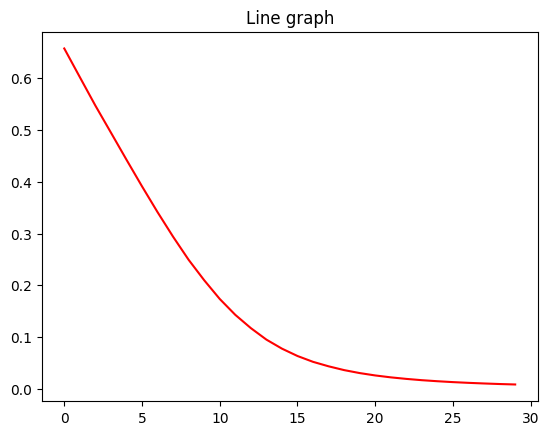

Correct: /n predicted:  0.009178382344543934 /n GT:  0
Correct: /n predicted:  0.9867333769798279 /n GT:  1
Correct: /n predicted:  0.9832677245140076 /n GT:  1
Correct: /n predicted:  0.010710615664720535 /n GT:  0
Correct: /n predicted:  0.009523488581180573 /n GT:  0
Correct: /n predicted:  0.00946970097720623 /n GT:  0
Correct: /n predicted:  0.009156154468655586 /n GT:  0
Correct: /n predicted:  0.9838084578514099 /n GT:  1
Correct: /n predicted:  0.008879047818481922 /n GT:  0
Correct: /n predicted:  0.9881154298782349 /n GT:  1
Correct: /n predicted:  0.9799246788024902 /n GT:  1
Correct: /n predicted:  0.009699522517621517 /n GT:  0
Correct: /n predicted:  0.9840751886367798 /n GT:  1
Correct: /n predicted:  0.008808777667582035 /n GT:  0
Correct: /n predicted:  0.978768527507782 /n GT:  1
Correct: /n predicted:  0.008914222940802574 /n GT:  0
Correct: /n predicted:  0.9835529327392578 /n GT:  1
Correct: /n predicted:  0.008892032317817211 /n GT:  0
Correct: /n predicted:  0.97

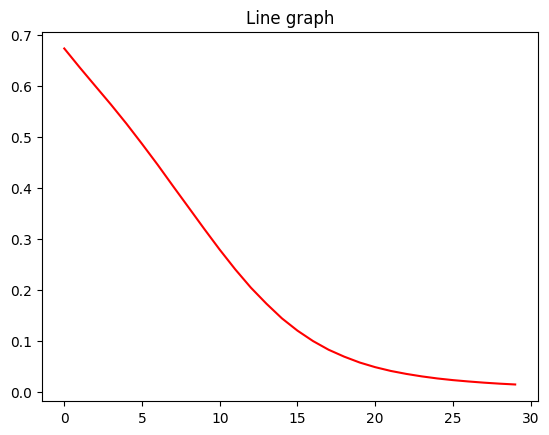

Correct: /n predicted:  0.008556287735700607 /n GT:  0
Correct: /n predicted:  0.9733433723449707 /n GT:  1
Correct: /n predicted:  0.9815210700035095 /n GT:  1
Correct: /n predicted:  0.010590680874884129 /n GT:  0
Correct: /n predicted:  0.008038703352212906 /n GT:  0
Correct: /n predicted:  0.008764440193772316 /n GT:  0
Correct: /n predicted:  0.009637538343667984 /n GT:  0
Correct: /n predicted:  0.9821866750717163 /n GT:  1
Correct: /n predicted:  0.008017854765057564 /n GT:  0
Correct: /n predicted:  0.9793877601623535 /n GT:  1
Correct: /n predicted:  0.9791299700737 /n GT:  1
Correct: /n predicted:  0.00911630317568779 /n GT:  0
Correct: /n predicted:  0.9825034737586975 /n GT:  1
Correct: /n predicted:  0.008595825172960758 /n GT:  0
Correct: /n predicted:  0.9445797801017761 /n GT:  1
Correct: /n predicted:  0.009021008387207985 /n GT:  0
Correct: /n predicted:  0.9619014859199524 /n GT:  1
Correct: /n predicted:  0.00844831857830286 /n GT:  0
Correct: /n predicted:  0.91215

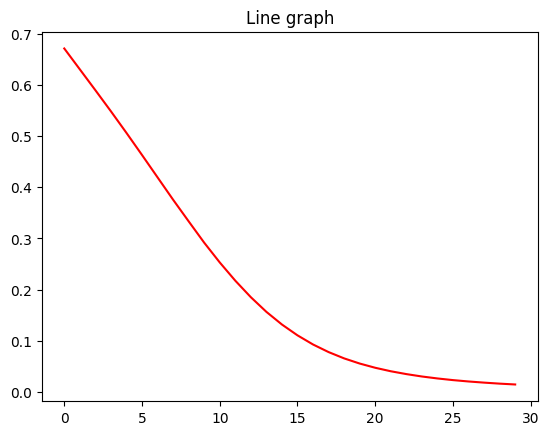

Correct: /n predicted:  0.015484359115362167 /n GT:  0
Correct: /n predicted:  0.9807091951370239 /n GT:  1
Correct: /n predicted:  0.9830385446548462 /n GT:  1
Correct: /n predicted:  0.016096968203783035 /n GT:  0
Correct: /n predicted:  0.01740168035030365 /n GT:  0
Correct: /n predicted:  0.01585487462580204 /n GT:  0
Correct: /n predicted:  0.019840456545352936 /n GT:  0
Correct: /n predicted:  0.9827399253845215 /n GT:  1
Correct: /n predicted:  0.01707526296377182 /n GT:  0
Correct: /n predicted:  0.9837644696235657 /n GT:  1
Correct: /n predicted:  0.9805567264556885 /n GT:  1
Correct: /n predicted:  0.01660558581352234 /n GT:  0
Correct: /n predicted:  0.9820805788040161 /n GT:  1
Correct: /n predicted:  0.01637357845902443 /n GT:  0
Correct: /n predicted:  0.965225875377655 /n GT:  1
Correct: /n predicted:  0.01787804439663887 /n GT:  0
Correct: /n predicted:  0.9745045304298401 /n GT:  1
Correct: /n predicted:  0.015631383284926414 /n GT:  0
Correct: /n predicted:  0.9488770

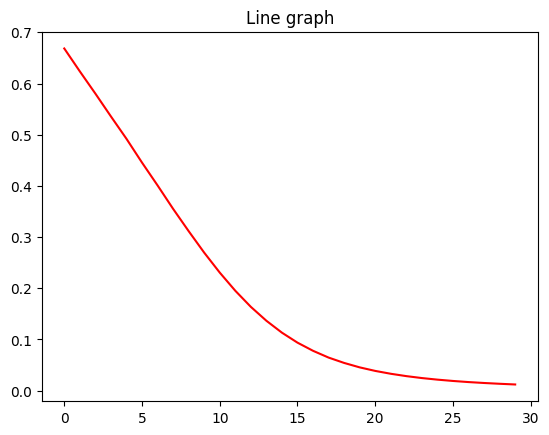

Correct: /n predicted:  0.01174824871122837 /n GT:  0
Correct: /n predicted:  0.9836840629577637 /n GT:  1
Correct: /n predicted:  0.9799124598503113 /n GT:  1
Correct: /n predicted:  0.014061709865927696 /n GT:  0
Correct: /n predicted:  0.012097484432160854 /n GT:  0
Correct: /n predicted:  0.012177848257124424 /n GT:  0
Correct: /n predicted:  0.013320941478013992 /n GT:  0
Correct: /n predicted:  0.9802991151809692 /n GT:  1
Correct: /n predicted:  0.011622241698205471 /n GT:  0
Correct: /n predicted:  0.9855495095252991 /n GT:  1
Correct: /n predicted:  0.976864755153656 /n GT:  1
Correct: /n predicted:  0.012631602585315704 /n GT:  0
Correct: /n predicted:  0.9805614352226257 /n GT:  1
Correct: /n predicted:  0.011908023618161678 /n GT:  0
Correct: /n predicted:  0.9705941081047058 /n GT:  1
Correct: /n predicted:  0.01251222100108862 /n GT:  0
Correct: /n predicted:  0.9788247346878052 /n GT:  1
Correct: /n predicted:  0.011595279909670353 /n GT:  0
Correct: /n predicted:  0.954

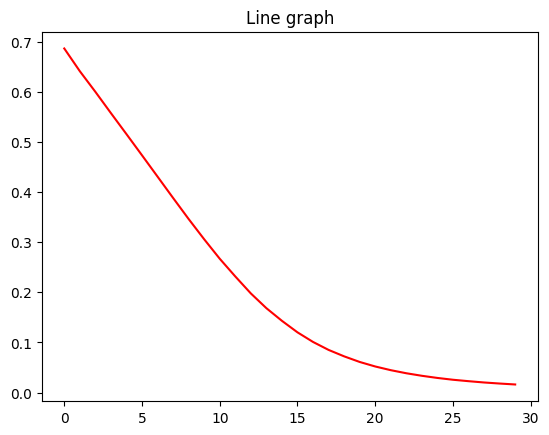

Correct: /n predicted:  0.005629515275359154 /n GT:  0
Correct: /n predicted:  0.9797440767288208 /n GT:  1
Correct: /n predicted:  0.9580336809158325 /n GT:  1
Correct: /n predicted:  0.007611274253576994 /n GT:  0
Correct: /n predicted:  0.004840624984353781 /n GT:  0
Correct: /n predicted:  0.005669139325618744 /n GT:  0
Correct: /n predicted:  0.0071340398862957954 /n GT:  0
Correct: /n predicted:  0.9623540043830872 /n GT:  1
Correct: /n predicted:  0.004431585315614939 /n GT:  0
Correct: /n predicted:  0.9795701503753662 /n GT:  1
Correct: /n predicted:  0.9520024061203003 /n GT:  1
Correct: /n predicted:  0.005724739748984575 /n GT:  0
Correct: /n predicted:  0.9662453532218933 /n GT:  1
Correct: /n predicted:  0.005959392990916967 /n GT:  0
Correct: /n predicted:  0.9759146571159363 /n GT:  1
Correct: /n predicted:  0.006457668263465166 /n GT:  0
Correct: /n predicted:  0.9784435033798218 /n GT:  1
Correct: /n predicted:  0.00570621807128191 /n GT:  0
Correct: /n predicted:  0.

In [164]:
# KFold training:
# KFold split:
k=5
kf = KFold(n_splits=k, random_state=None, shuffle=False)

# KFold split:
#for i, (train_index, test_index) in enumerate(kf.split(All_data)):
#  print(f"Fold {i}:")
#  print(f"  Train: index={len(train_index)}")
#  print(f"  Test:  index={len(test_index)}")

acc_score = []

for fold_indx, (train_index, test_index) in enumerate(kf.split(All_data)):
  #print(f"Fold {fold_indx}:")
  #print(f"  Train: index={train_index}")
  #print(f"  Test:  index={test_index}")

  print('Fold: ', fold_indx)
  print('Training epochs...')
  # Training dataset:
  train_data = []
  for i in range(len(train_index)):
    train_data.append(All_data[train_index[i]])
  # Testing dataset:
  test_data = []
  for j in range(len(test_index)):
    test_data.append(All_data[test_index[j]])

  dataset = DataLoader(train_data, batch_size=10, shuffle = True)

  # Train model:
  fold_model_name = TRAIN_MODEL(dataset, fold_indx)

  # Check accuracy of model of fold:
  clf = ImageClassifier()
  with open(fold_model_name, 'rb') as f:
    clf.load_state_dict(load(f))

  clf.eval()

  correct = 0
  wrong = 0

  with torch.no_grad():
    for index in range(len(Full_data)):
      ECG_test_tensor = Full_data[index][0].unsqueeze(0)
      predval = clf(ECG_test_tensor).item()
      if (predval>0.5):
        pred = 1
      else:
        pred = 0

      #print('Prediction = ', predval, ' which equates to ', pred)
      #print('GT = ', test_data[index][1][0])
      if (pred==Full_data[index][1][0]):
        print('Correct: /n', 'predicted: ', predval, '/n GT: ', Full_data[index][1][0])
        correct = correct+1
      else:
        print('Wrong, ', pred, ' != ', Full_data[index][1][0])
        wrong = wrong+1
    print('Accuracy for fold ', fold_indx, ' = ', correct/len(Full_data))
    print('_____________________________________')
    acc_score.append(correct/len(Full_data))

avg_acc_score = 10

#print('accuracy of each fold - {}'.format(acc_score))
print('Avg accuracy = ', sum(acc_score)/len(acc_score))

In [162]:
# Check accuracy for unseen ECG traces:

# Initialise all data sets:
# Values:

print('Loading')

for f in range(1):
    abs_file_path = '/content/drive/MyDrive/KURF2023/TEST MODEL location/ECGtrace_SP_0_Center_75_75_iterns_6000_position_80comma80_LiiLiiiWTCV1V2V3V4V5V6aVF.txt'
    c1Start = abs_file_path.find('er_') + 3
    c1End = c1Start+2
    c2End = abs_file_path.find('_ite')
    c2Start = c2End-2
    C1 = int(abs_file_path[c1Start:c1End])
    C2 = int(abs_file_path[c2Start:c2End])
    Coords = [C1,C2]
    print(abs_file_path)
    Pwaves_Lii = np.zeros(count)
    Pwaves_Liii = np.zeros(count)
    Pwaves_WCT = np.zeros(count)
    Pwaves_V1 = np.zeros(count)
    Pwaves_V2 = np.zeros(count)
    Pwaves_V3 = np.zeros(count)
    Pwaves_V4 = np.zeros(count)
    Pwaves_V5 = np.zeros(count)
    Pwaves_V6 = np.zeros(count)
    Pwaves_aVF = np.zeros(count)

    ECGfile = open(abs_file_path, 'r');
    # Using for loop to read in the data:
    iteration = 0
    for lineRead in ECGfile:
        listFloats = lineRead.split("\t")
        x = list(np.float_(listFloats))
        Pwaves_Lii[iteration] = x[0]
        Pwaves_Liii[iteration] = x[1]
        Pwaves_WCT[iteration] = x[2]
        Pwaves_V1[iteration] = x[3]
        Pwaves_V2[iteration] = x[4]
        Pwaves_V3[iteration] = x[5]
        Pwaves_V4[iteration] = x[6]
        Pwaves_V5[iteration] = x[7]
        Pwaves_V6[iteration] = x[8]
        Pwaves_aVF[iteration] = x[9]
        iteration += 1
    ECG_Set_val = [Pwaves_Lii, Pwaves_Liii, Pwaves_WCT, Pwaves_V1, Pwaves_V2, Pwaves_V3, Pwaves_V4, Pwaves_V5, Pwaves_V6, Pwaves_aVF]
    # Close file:
    ECGfile.close()
print('Finished')

# Check accuracy on inseen data:
fold_model_name = 'Model_state0.pt'
clf = ImageClassifier()
with open(fold_model_name, 'rb') as f:
  clf.load_state_dict(load(f))

clf.eval()

#try with a tuple
correct = 0
wrong = 0

with torch.no_grad():
  for index in range(1):
    ECG_test_tensor = torch.from_numpy(np.float32(ECG_Set_val)).unsqueeze(0)
    predval = clf(ECG_test_tensor).item()
    if (predval>0.5):
      pred = 1
    else:
      pred = 0
    print('predicted: ', predval, ' which equates to ', Possible_coordinates[round(predval)])
    print('True location = ', Coords)
    correct = correct+1

Loading
/content/drive/MyDrive/KURF2023/TEST MODEL location/ECGtrace_SP_0_Center_75_75_iterns_6000_position_80comma80_LiiLiiiWTCV1V2V3V4V5V6aVF.txt
Finished
predicted:  0.9668070673942566  which equates to  [75, 75]
True location =  [75, 75]


In [163]:
# Test zone:
# Print all filenames:
#
ECG_test = np.float32(All_ECG_Sets[index])
ECG_test_tensor = ToTensor()(ECG_test)
ECG_test_tensor2 = test_data[index][0].unsqueeze(0)
print(len(ECG_test_tensor[0][0]))
print(len(ECG_test_tensor2[0][0]))

3500
3500
